In [1]:
from nn import TopologyMixin

# PyTorch model and training necessities
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

# Image datasets and image manipulation
import torchvision
import torchvision.transforms as transforms

# Image display
import matplotlib.pyplot as plt
import numpy as np

# PyTorch TensorBoard support
from torch.utils.tensorboard import SummaryWriter

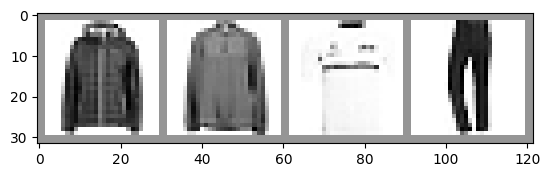

In [2]:
# Gather datasets and prepare them for consumption
transform = transforms.Compose(
    [transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))])

# Store separate training and validations splits in ./data
training_set = torchvision.datasets.FashionMNIST('./data',
    download=True,
    train=True,
    transform=transform)
validation_set = torchvision.datasets.FashionMNIST('./data',
    download=True,
    train=False,
    transform=transform)

training_loader = torch.utils.data.DataLoader(training_set,
                                              batch_size=4,
                                              shuffle=True,
                                              num_workers=2)


validation_loader = torch.utils.data.DataLoader(validation_set,
                                                batch_size=4,
                                                shuffle=False,
                                                num_workers=2)

# Class labels
classes = ('T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
        'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle Boot')

# Helper function for inline image display
def matplotlib_imshow(img, one_channel=False):
    if one_channel:
        img = img.mean(dim=0)
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    if one_channel:
        plt.imshow(npimg, cmap="Greys")
    else:
        plt.imshow(np.transpose(npimg, (1, 2, 0)))

# Extract a batch of 4 images
dataiter = iter(training_loader)
images, labels = next(dataiter)

# Create a grid from the images and show them
img_grid = torchvision.utils.make_grid(images)
matplotlib_imshow(img_grid, one_channel=True)

In [3]:
# Default log_dir argument is "runs" - but it's good to be specific
# torch.utils.tensorboard.SummaryWriter is imported above
writer = SummaryWriter('runs/fashion_mnist_experiment_3')

# Write image data to TensorBoard log dir
writer.add_image('Four Fashion-MNIST Images', img_grid)
writer.flush()

# To view, start TensorBoard on the command line with:
#   tensorboard --logdir=runs
# ...and open a browser tab to http://localhost:6006/

In [11]:
class Net(nn.Module, TopologyMixin):
    def __init__(self):
        nn.Module.__init__(self)
        TopologyMixin.__init__(self, writer=writer)
        
        self.conv1 = nn.Conv2d(1, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 4 * 4, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x, topology: bool = False):
        if topology:
            self.Filtration(x.transpose(1, 2).transpose(2, 3), label='Input', distances=False, batches=True)
            self.Dimension(x.transpose(1, 2).transpose(2, 3), label='Dimension Analysis', distances=False, batches=True)
            self.DeltaHyperbolicity(x.transpose(1, 2).transpose(2, 3), label='Hyperbolicity Analysis', distances=False, batches=True)
            
            x = self.pool(F.relu(self.conv1(x)))
            x = self.pool(F.relu(self.conv2(x)))
            self.Filtration(x.transpose(1, 2).transpose(2, 3), label='Hidden', distances=False, batches=True)
            self.Dimension(x.transpose(1, 2).transpose(2, 3), label='Dimension Analysis', distances=False, batches=True)
            self.DeltaHyperbolicity(x.transpose(1, 2).transpose(2, 3), label='Hyperbolicity Analysis', distances=False, batches=True)
            
            x = x.view(-1, 16 * 4 * 4)
            x = F.relu(self.fc1(x))
            x = F.relu(self.fc2(x))
            x = self.fc3(x)
            
            return x
        
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 4 * 4)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


net = Net()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [5]:
list(net.children())

[Persistence(),
 IntrinsicDimension(),
 Entropy(),
 DeltaHyperbolicity(),
 Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1)),
 MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False),
 Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1)),
 Linear(in_features=256, out_features=120, bias=True),
 Linear(in_features=120, out_features=84, bias=True),
 Linear(in_features=84, out_features=10, bias=True)]

In [15]:
net._modules

RecursionError: maximum recursion depth exceeded

In [11]:
net.train(True)

RecursionError: maximum recursion depth exceeded while calling a Python object

In [12]:
# Log Validation Results
net.eval()
vdata = next(iter(validation_loader))
vinputs, vlabels = vdata
voutputs = net(vinputs, topology=True)
vloss = criterion(voutputs, vlabels)

In [8]:
x = vinputs
x.shape

torch.Size([4, 1, 28, 28])

In [9]:
x = net.pool(F.relu(net.conv1(x)))
x = net.pool(F.relu(net.conv2(x)))
x.shape

torch.Size([4, 16, 4, 4])

In [10]:
x.transpose(0, 1).transpose(1, 2).shape

torch.Size([16, 4, 4, 4])

In [10]:
(vinputs[0] / 2 + 0.5).transpose(0, 1).transpose(1, 2)

tensor([[[0.0000],
         [0.0000],
         [0.0000],
         [0.0000],
         [0.0000],
         [0.0000],
         [0.0000],
         [0.0000],
         [0.0000],
         [0.0000],
         [0.0000],
         [0.0000],
         [0.0000],
         [0.0000],
         [0.0000],
         [0.0000],
         [0.0000],
         [0.0000],
         [0.0000],
         [0.0000],
         [0.0000],
         [0.0000],
         [0.0000],
         [0.0000],
         [0.0000],
         [0.0000],
         [0.0000],
         [0.0000]],

        [[0.0000],
         [0.0000],
         [0.0000],
         [0.0000],
         [0.0000],
         [0.0000],
         [0.0000],
         [0.0000],
         [0.0000],
         [0.0000],
         [0.0000],
         [0.0000],
         [0.0000],
         [0.0000],
         [0.0000],
         [0.0000],
         [0.0000],
         [0.0000],
         [0.0000],
         [0.0000],
         [0.0000],
         [0.0000],
         [0.0000],
         [0.0000],
         [

In [5]:
print(len(validation_loader))
for epoch in range(1):  # loop over the dataset multiple times
    running_loss = 0.0

    for i, data in enumerate(training_loader, 0):
        # basic training loop
        inputs, labels = data
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        if i % 1000 == 999:    # Every 1000 mini-batches...
            print('Batch {}'.format(i + 1))
            # Check against the validation set
            running_vloss = 0.0

            # In evaluation mode some model specific operations can be omitted eg. dropout layer
            net.train(False) # Switching to evaluation mode, eg. turning off regularisation
            
            # Log Validation Results
            vdata = next(iter(validation_loader))
            vinputs, vlabels = vdata
            voutputs = net(vinputs, topology=True)
            vloss = criterion(voutputs, vlabels)
            running_vloss += vloss.item()
            
            for j, vdata in enumerate(validation_loader, 0):
                vinputs, vlabels = vdata
                voutputs = net(vinputs)
                vloss = criterion(voutputs, vlabels)
                running_vloss += vloss.item()
            net.train(True) # Switching back to training mode, eg. turning on regularisation

            avg_loss = running_loss / 1000
            avg_vloss = running_vloss / len(validation_loader)

            # Log the running loss averaged per batch
            writer.add_scalars('Training vs. Validation Loss',
                            { 'Training' : avg_loss, 'Validation' : avg_vloss },
                            epoch * len(training_loader) + i)

            running_loss = 0.0
print('Finished Training')

writer.flush()

2500
Batch 1000


RecursionError: maximum recursion depth exceeded while calling a Python object

In [7]:
net.Filtration.parent

RecursionError: maximum recursion depth exceeded while getting the repr of an object

In [19]:
vdata = next(iter(validation_loader))
vinputs, vlabels = vdata
d = image_distance(vinputs[0].unsqueeze(0)).unsqueeze(0)
d

tensor([[[0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
          0.0000e+00, 0.0000e+00, 2.9638e-01, 1.1652e+00, 1.9318e+00,
          3.7456e+00, 3.9942e+00, 3.9800e+00, 4.0337e+00, 4.2469e+00,
          4.4195e+00, 4.6912e+00, 5.1273e+00, 5.4278e+00, 6.0498e+00,
          7.8098e+00, 5.9371e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
          0.0000e+00, 0.0000e+00, 0.0000e+00],
         [0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
          0.0000e+00, 0.0000e+00, 2.9638e-01, 1.1652e+00, 1.9318e+00,
          3.7456e+00, 3.9942e+00, 3.9800e+00, 4.0337e+00, 4.2469e+00,
          4.4195e+00, 4.6912e+00, 5.1273e+00, 5.4278e+00, 6.0498e+00,
          7.8098e+00, 5.9371e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
          0.0000e+00, 0.0000e+00, 0.0000e+00],
         [0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
          0.0000e+00, 0.0000e+00, 2.9638e-01, 1.1652e+00, 1.9318e+00,
          3.7456e+00, 3.9942e+00, 3.9800e+00, 4.0337e+00, 4.2469e+

In [7]:
from gtda.homology import VietorisRipsPersistence
from gtda.diagrams import BettiCurve

VR = VietorisRipsPersistence(metric='precomputed')
Betti = BettiCurve()
pi = VR.fit_transform(d)
bc = Betti.fit_transform(pi)

In [11]:
bc

array([[[ 9, 15, 15, 15, 15, 15, 15, 15, 15, 15, 14, 14, 14, 14, 14, 14,
         14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 13, 13, 12, 12, 11, 10,
         10, 10, 10, 10,  7,  7,  7,  7,  7,  6,  5,  5,  5,  5,  5,  5,
          5,  5,  4,  4,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,
          3,  3,  3,  3,  3,  3,  3,  3,  3,  2,  2,  2,  2,  2,  2,  2,
          2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  1,  1,  1,
          1,  1,  1,  0],
        [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
          0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
          0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
          0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
          0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
          0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
          0,  0,  0,  0]]])

In [20]:
from dadapy import data

dim = data.Data(distances=d[0].numpy()).compute_id_2NN()[0]

ValueError: array must not contain infs or NaNs

In [22]:
eqv = [list()] * d[0].shape[0]


array([[0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00,
        0.00e+00, 2.96e-01, 1.17e+00, 1.93e+00, 3.75e+00, 3.99e+00,
        3.98e+00, 4.03e+00, 4.25e+00, 4.42e+00, 4.69e+00, 5.13e+00,
        5.43e+00, 6.05e+00, 7.81e+00, 5.94e+00, 0.00e+00, 0.00e+00,
        0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00],
       [0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00,
        0.00e+00, 2.96e-01, 1.17e+00, 1.93e+00, 3.75e+00, 3.99e+00,
        3.98e+00, 4.03e+00, 4.25e+00, 4.42e+00, 4.69e+00, 5.13e+00,
        5.43e+00, 6.05e+00, 7.81e+00, 5.94e+00, 0.00e+00, 0.00e+00,
        0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00],
       [0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00,
        0.00e+00, 2.96e-01, 1.17e+00, 1.93e+00, 3.75e+00, 3.99e+00,
        3.98e+00, 4.03e+00, 4.25e+00, 4.42e+00, 4.69e+00, 5.13e+00,
        5.43e+00, 6.05e+00, 7.81e+00, 5.94e+00, 0.00e+00, 0.00e+00,
        0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00],
       [0.00e+00, 0.00e+00, 0.00e+00,

In [18]:
any(list(d.isinf().flatten()))

False

In [1]:
from dadapy.data import Data
import torch

z = torch.zeros((3, 3))
Data(distances=z.numpy()).compute_id_2NN()[0]

/Users/andrew/PycharmProjects/tadProject/.venv/lib/python3.9/site-packages/dadapy/id_estimation.py:175: RuntimeWarning: invalid value encountered in divide
  mus = self.distances[:, 2] / self.distances[:, 1]


ValueError: array must not contain infs or NaNs